# Classifying COVID-19 Deaths Using KNN, Logistic Regression, and Naive Bayes
## by Mostafa Lotfy and Youssef Maher

First we import some libraries and methods that will prove useful later on.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score,roc_auc_score, accuracy_score, f1_score, make_scorer, roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import BaggingClassifier
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


We read the data from the 'data.csv' file and then look at the numerical summary of the different columns.

In [2]:
df = pd.read_csv('data.csv',index_col=0)
df.describe()

,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
count,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.00000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000
mean,76.645423,16.995365,0.849363,49.400000,0.181924,0.107764,12.13905,28.002317,18.298957,11.840093,2.993048,0.998841,0.995365,0.125145
std,39.200264,7.809951,0.726062,15.079203,0.386005,0.310261,3.99787,7.473231,2.864064,1.183771,0.127251,0.034040,2.358767,0.331075
min,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.000000,0.000000
25%,45.000000,11.000000,0.000000,40.000000,0.000000,0.000000,14.00000,31.000000,19.000000,12.000000,3.000000,1.000000,0.000000,0.000000
50%,87.000000,18.000000,1.000000,49.400000,0.000000,0.000000,14.00000,31.000000,19.000000,12.000000,3.000000,1.000000,0.000000,0.000000
75%,110.000000,24.000000,1.000000,57.000000,0.000000,0.000000,14.00000,31.000000,19.000000,12.000000,3.000000,1.000000,1.000000,0.000000
max,138.000000,33.000000,2.000000,96.000000,1.000000,1.000000,24.00000,31.000000,19.000000,12.000000,3.000000,1.000000,15.000000,1.000000


We then analyze our data visually by plotting histograms of each feature.

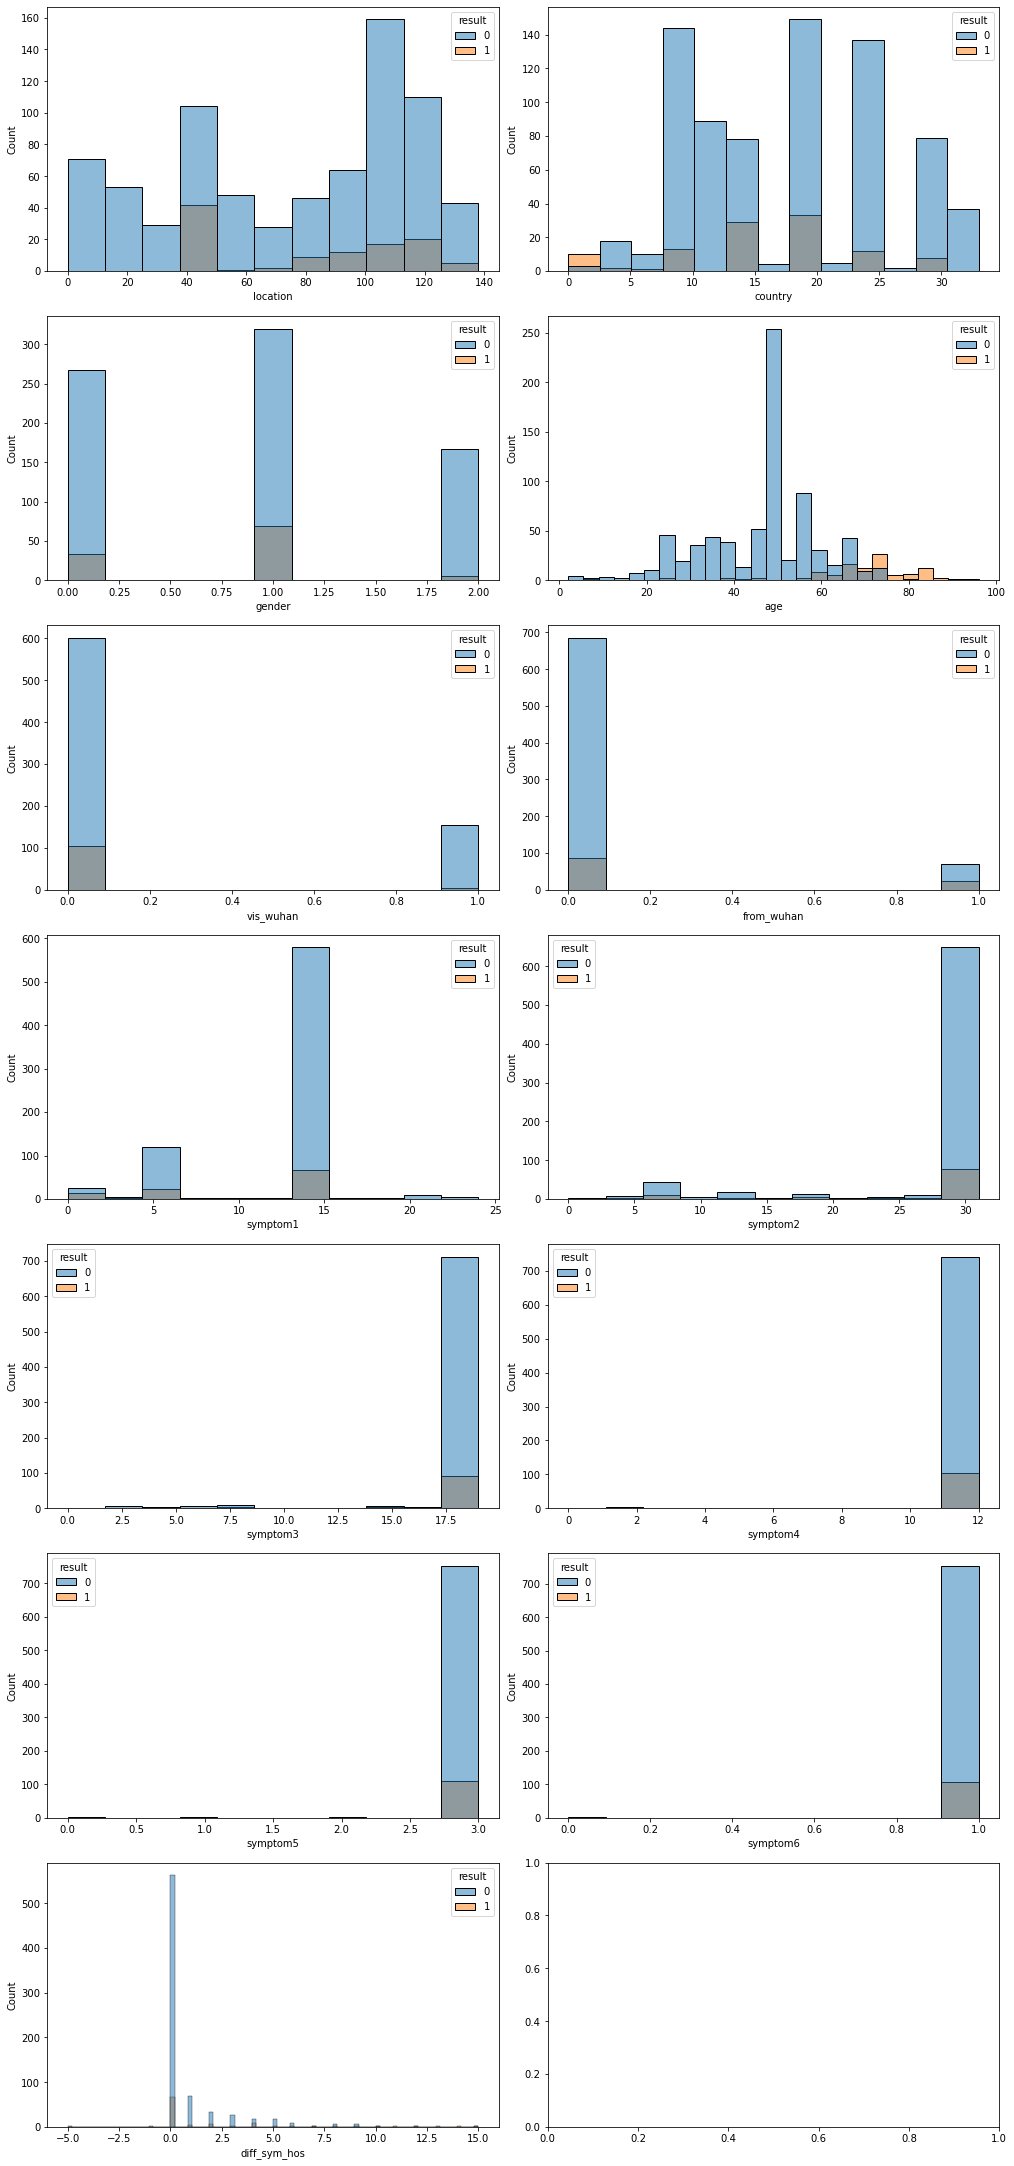

In [3]:
fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(14, 30))
for i in range(13):
    sns.histplot(x=df.columns[i],hue='result',data=df, ax=ax[i//2][i%2])

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

Next, we create a correlation graph between all the features within the dataset.

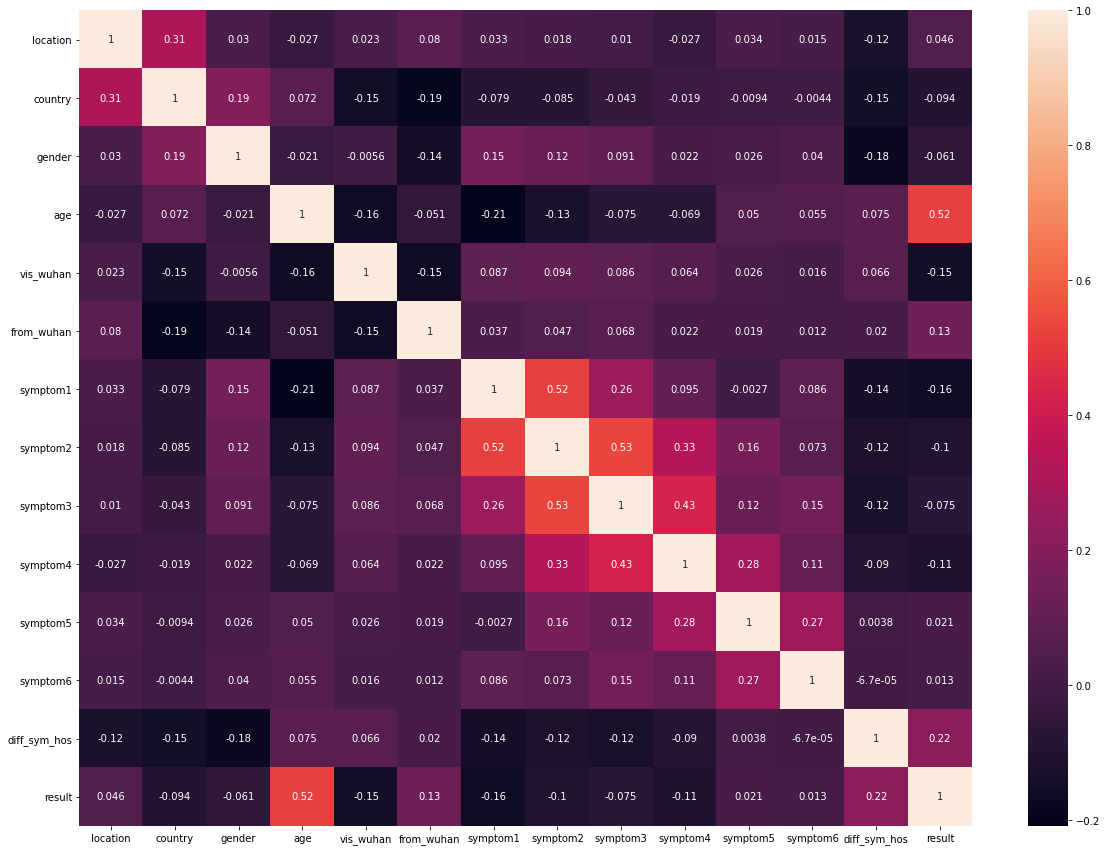

In [4]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(20,15))
ax = sns.heatmap(corr, annot=True)

> By inspecting the correlation matrix we can observe that the result is highly correlated with "age" and "diff_sym_hos".
>
> Furthermore, there is a large correlation between symptom2 and symptom1, symptom3 and symptom2.
>
> Additionally, we can see there is very little correlation between the result and symptom6 and symptom5.

# Cleaning
By inspecting the values in the different columns we noticed some irregular values especially in the gender and diff_sym_hos columns.

In [5]:
#Negative hours changed to positive
for i in range(len(df)):
    df.iloc[i, 12] = df.iloc[i,12]*-1 if df.iloc[i, 12] < 0 else df.iloc[i, 12]

#Gender value 2 changed to the most common gender
df['gender'] = df['gender'].mask(df['gender'] == 2, 1)

# Functions
These methods will be used to perform different operations such as dropping, encoding, and scaling features in the data. As well as splitting the dataframe to train, test, and validation sets.

In [6]:
# drop columns form the given data frame
def drop(dropped_columns, df):
    df_dropped = df.copy()
    for col in dropped_columns:
        df_dropped.drop(col, axis=1, inplace=True)
    return df_dropped

In [7]:
# one hot encoding
def encode(columns, df):
    df_encoded = df.copy()
    for col in columns:
        encoding = pd.get_dummies(df[col], prefix=col)
        df_encoded = df_encoded.join(encoding)
        df_encoded.drop(col, axis=1, inplace=True)
    return df_encoded

In [8]:
# scaling
def scale(scaled_columns, df):
    df_scaled = df.copy()
    scaler = MinMaxScaler()
    for col in scaled_columns:
        df_scaled[col] = scaler.fit_transform(df_scaled[col].to_numpy()[:,np.newaxis])[:,0]
    return df_scaled

In [9]:
# Splits the given dataframe into 70% training set, 15% validation set, 15% testing set
def split(df):
    x = df.drop('result', axis=1)
    y = df['result']
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3,shuffle=True, random_state=42)
    X_validate, X_test, y_validate, y_test = train_test_split(X_test, y_test, test_size=0.5,shuffle=True, random_state=42)
    return X_train, X_validate, X_test, y_train, y_validate, y_test

This method is given a classifier and the testing data and then returns the different evaluation metrics needed. For precision and recall metrics the value of the metric of the zero-class is shown first then the positive class.

In [10]:
def predict_and_score(clf,X, y, average=None):
    y_predict = clf.predict(X)
    precision= precision_score(y, y_predict,average=average)
    recall = recall_score(y,y_predict,average=average)
    roc_auc = roc_auc_score(y, y_predict)
    F1 = f1_score(y, y_predict)
    return precision, recall, F1, roc_auc

The following three methods perform hyperparameter tuning on the different required algorithms by providing them with the training set and the validation set and the metric on which the performance of the models is evaluated, then they return the best hyperparamteres found.

Here we use recall as the default metric for evaluation as we need to increase the rate 

$ True Positive / (True Positive + False Negative) $

Which means of all the people who are going to die we classify as many as possible correctly.

In [11]:
def knn_validate(X_train, X_validate, y_train, y_validate, score='recall'):
    dic = {'clf':[], 'recall':[], 'precision':[], 'f1':[], 'roc_auc':[]}
    
    # Whether the algorithm should take into account the distance of a neighbour when it performs voting
    weights = ['distance', 'uniform']
    
    # K should be an odd number to avoid voting ties, and should be >= 1 and < sqrt(number of samples)
    for k in range(1, int(len(X_train) ** 0.5), 2):
        for weight in weights: 
            
            knn = KNeighborsClassifier(n_neighbors=k, weights=weight)
            knn.fit(X_train, y_train)
            precision, recall, roc_auc, F1 = predict_and_score(knn, X_validate, y_validate, 'binary')
            dic['clf'].append(knn)
            dic['recall'].append(recall)
            dic['precision'].append(precision)
            dic['f1'].append(F1)
            dic['roc_auc'].append(roc_auc)
            
    df_scores = pd.DataFrame(dic)
    max_index = df_scores[score].idxmax()
    return df_scores.iloc[max_index, 0]

In [12]:
def logistic_validate(X_trian, X_validate, y_train, y_validate, score='recall'):
    dic = {'clf':[], 'recall':[], 'precision':[], 'f1':[], 'roc_auc':[]}
    
    weights = []
    for i in np.arange(0.01,1,0.05):
        weights.append({0:1 - i, 1:i})

    weights.append('balanced')
    
    # the weights are the weight of each class in the classification
    
    for weight in weights: 
        
        logistic = LogisticRegression(class_weight=weight,random_state=42, max_iter=1000)
        logistic.fit(X_train, y_train)
        precision, recall, roc_auc, F1 = predict_and_score(logistic, X_validate, y_validate, 'binary')
        dic['clf'].append(logistic)
        dic['recall'].append(recall)
        dic['precision'].append(precision)
        dic['f1'].append(F1)
        dic['roc_auc'].append(roc_auc)
    df_scores = pd.DataFrame(dic)
    max_index = df_scores[score].idxmax()
    return df_scores.iloc[max_index, 0]

In [13]:
def gnb_validate(X_train, X_validate, y_train, y_validate, score='recall'):
    dic = {'clf':[], 'recall':[], 'precision':[], 'f1':[], 'roc_auc':[]}
    
    #var_smoothing adds a value to the distribution's variance to smooth out the curve 
    for var in np.logspace(0,-9, num=100): 
        gnb = GaussianNB(var_smoothing=var)
        gnb.fit(X_train, y_train)
        precision, recall, roc_auc, F1 = predict_and_score(gnb, X_validate, y_validate, 'binary')
        dic['clf'].append(gnb)
        dic['recall'].append(recall)
        dic['precision'].append(precision)
        dic['f1'].append(F1)
        dic['roc_auc'].append(roc_auc)
    df_scores = pd.DataFrame(dic)
    max_index = df_scores[score].idxmax()
    return df_scores.iloc[max_index, 0]

In [14]:
def draw_roc_curve(clf,X_test,y_test):
    y_predict =  clf.predict_proba(X_test)
    y_pred_proba = y_predict[::,1]
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

This function takes a classifier and the training and testing set. To fit the model then perform testing and return the evaluation metrics.

In [15]:
def train_test(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)
    return predict_and_score(clf, X_test, y_test)

# KNN

## Hyperparamter Tuning Using Training, Validation, and Test Sets
First we attempt to get the best hyperparameters by splitting the data in training, validation, and Test sets and then fitting different models with different hyperparameters and evaluating the performance on the validation set. We then test the best model using the testing data to obtain our metrics.

### No Encoding
First we attempt to fit the model without any changes to act as a baseline.

KNeighborsClassifier(n_neighbors=1, weights='distance')

Precision: [0.94782609 0.86666667]
Recall: [0.98198198 0.68421053]
F1: 0.7647058823529413
ROC_AUC: 0.8330962541488857


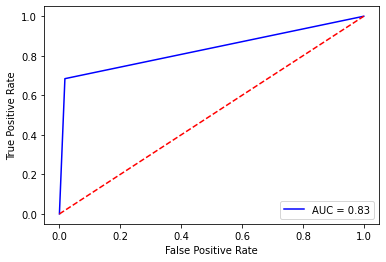

In [16]:
X_train, X_validate, X_test, y_train, y_validate, y_test = split(df)
best_knn = knn_validate(X_train, X_validate, y_train, y_validate)
print(best_knn)
precision,recall,f1,roc_auc = train_test(best_knn, X_train, X_test, y_train, y_test)
print(f"\nPrecision: {precision}\nRecall: {recall}\nF1: {f1}\nROC_AUC: {roc_auc}")
draw_roc_curve(best_knn,X_test,y_test)

## One-Hot Encoding
We then encode some of the categorical data in the dataset to improve the metrics.

KNeighborsClassifier(n_neighbors=7, weights='distance')
Precision: [0.93162393 0.84615385]
Recall: [0.98198198 0.57894737]
F1: 0.6875
ROC_AUC: 0.7804646752015173


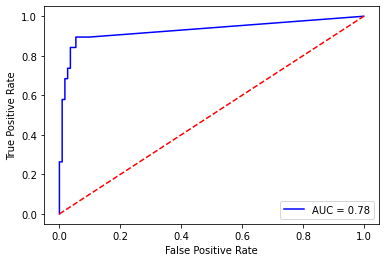

In [17]:
encoded_columns =['symptom1', 'symptom2', 'symptom3', 'symptom4', 'symptom5', 'symptom6', 'location', 'country']
df_encoded = encode(encoded_columns, df)
X_train, X_validate, X_test, y_train, y_validate, y_test = split(df_encoded)
best_knn = knn_validate(X_train, X_validate, y_train, y_validate)
print(best_knn)
precision,recall,f1,roc_auc = train_test(best_knn, X_train, X_test, y_train, y_test)
print(f"Precision: {precision}\nRecall: {recall}\nF1: {f1}\nROC_AUC: {roc_auc}")
draw_roc_curve(best_knn,X_test,y_test)

## Scaling
We then scale the values of the larger dimensions such as 'diff_sym_hos'. In theory we should also scale the age feature, however, experimentally not scaling age results in better metrics. This is explainable by the fact that the result is highly correleated with age, which we know about COVID from a medical perpective. So as such the model should highly favour age in its classification of the result.

KNeighborsClassifier(n_neighbors=3, weights='distance')
Precision: [0.94782609 0.86666667]
Recall: [0.98198198 0.68421053]
F1: 0.7647058823529413
ROC_AUC: 0.8330962541488857


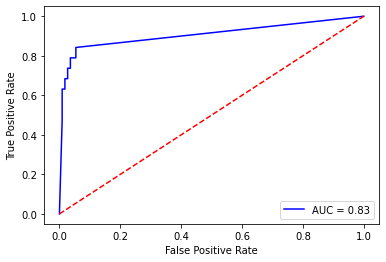

In [18]:
scaled_columns=['diff_sym_hos']
df_scaled = scale(scaled_columns,df_encoded )
X_train, X_validate, X_test, y_train, y_validate, y_test = split(df_scaled)
best_knn = knn_validate(X_train, X_validate, y_train, y_validate)
print(best_knn)
precision,recall,f1,roc_auc = train_test(best_knn, X_train, X_test, y_train, y_test)
print(f"Precision: {precision}\nRecall: {recall}\nF1: {f1}\nROC_AUC: {roc_auc}")
draw_roc_curve(best_knn,X_test,y_test)

KNeighborsClassifier(n_neighbors=1, weights='distance')
Precision: [0.90517241 0.57142857]
Recall: [0.94594595 0.42105263]
F1: 0.48484848484848486
ROC_AUC: 0.6834992887624467


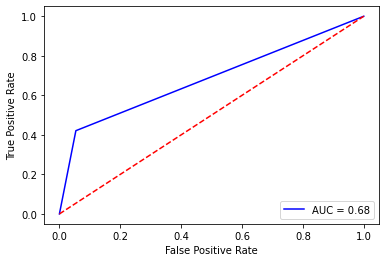

In [19]:
scaled_columns =['age', 'diff_sym_hos']
df_scaled = scale(scaled_columns,df_encoded )
X_train, X_validate, X_test, y_train, y_validate, y_test = split(df_scaled)
best_knn = knn_validate(X_train, X_validate, y_train, y_validate)
print(best_knn)
precision,recall,f1,roc_auc = train_test(best_knn, X_train, X_test, y_train, y_test)
print(f"Precision: {precision}\nRecall: {recall}\nF1: {f1}\nROC_AUC: {roc_auc}")
draw_roc_curve(best_knn,X_test,y_test)

> This shows experimentally that 'age' should not be scaled.

## Feature Selection
Previously, we discussed how symptoms 1, 2, and 3 were highly correleated with one another. Additionally, symptom6 had very little correlation with the result. So we drop symptoms 2 and 3 and leave symptom1, then drop symptom6.

KNeighborsClassifier(n_neighbors=1, weights='distance')
Precision: [0.95689655 1.        ]
Recall: [1.         0.73684211]
F1: 0.8484848484848484
ROC_AUC: 0.868421052631579


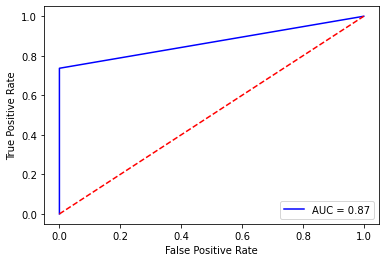

In [20]:
dropped_columns = ['symptom2', 'symptom3', 'symptom6']
encoded_columns =['location', 'symptom1','country','symptom4','symptom5']
scaled_columns=['diff_sym_hos']
df_dropped = drop(dropped_columns, df)
df_encoded = encode(encoded_columns,df_dropped)
df_scaled = scale(scaled_columns,df_encoded )
X_train, X_validate, X_test, y_train, y_validate, y_test = split(df_scaled)
best_knn = knn_validate(X_train, X_validate, y_train, y_validate)
print(best_knn)
precision,recall,f1,roc_auc = train_test(best_knn, X_train, X_test, y_train, y_test)
print(f"Precision: {precision}\nRecall: {recall}\nF1: {f1}\nROC_AUC: {roc_auc}")
draw_roc_curve(best_knn,X_test,y_test)

## Further Experimentation
Here we experimentally select features. After some experiments this is the best result.

KNeighborsClassifier(n_neighbors=1, weights='distance')
Precision: [0.96460177 0.88235294]
Recall: [0.98198198 0.78947368]
F1: 0.8333333333333333
ROC_AUC: 0.8857278330962541


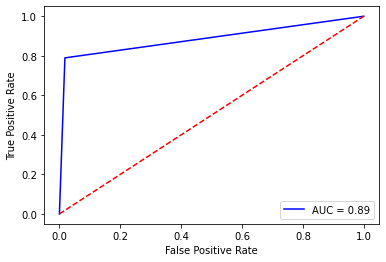

In [21]:
dropped_columns = ['symptom2', 'symptom3','symptom5', 'symptom6','country','symptom4']
encoded_columns =['location', 'symptom1']
scaled_columns=['diff_sym_hos']
df_dropped = drop(dropped_columns, df)
df_encoded = encode(encoded_columns,df_dropped)
df_scaled = scale(scaled_columns,df_encoded )
X_train, X_validate, X_test, y_train, y_validate, y_test = split(df_scaled)
best_knn = knn_validate(X_train, X_validate, y_train, y_validate)
print(best_knn)
precision,recall,f1,roc_auc = train_test(best_knn, X_train, X_test, y_train, y_test)
print(f"Precision: {precision}\nRecall: {recall}\nF1: {f1}\nROC_AUC: {roc_auc}")
draw_roc_curve(best_knn,X_test,y_test)

## Using GridSearch to Find Optimal Hyperparameters and Perform Cross-Validation

KNeighborsClassifier(n_neighbors=3, weights='distance')
Precision: [0.96137339 0.88461538]
Recall: [0.98678414 0.71875   ]
F1: 0.7931034482758621
ROC_AUC: 0.8527670704845816


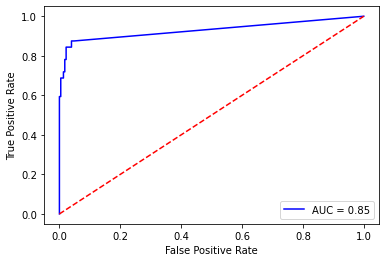

In [22]:
dropped_columns = ['symptom2', 'symptom3','symptom6']
encoded_columns =['location', 'symptom1','symptom5','country','symptom4']
scaled_columns=['diff_sym_hos']
df_dropped = drop(dropped_columns, df)
df_encoded = encode(encoded_columns,df_dropped)
df_scaled = scale(scaled_columns,df_encoded)
x = df_scaled.drop('result', axis=1)
y = df_scaled['result']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3,shuffle=True, random_state=42)
parameters = {'n_neighbors': np.arange(1, int(len(X_train) ** 0.5), 2),
     'weights':['distance','uniform']}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, parameters, scoring='recall', cv=5)
grid_search.fit(X_train, y_train)
best_knn = grid_search.best_estimator_
best_knn.fit(X_train, y_train)
y_predict = best_knn.predict(X_test)
precision= precision_score(y_test, y_predict,average=None)
recall = recall_score(y_test,y_predict,average=None)
roc_auc = roc_auc_score(y_test, y_predict)
f1 = f1_score(y_test.values, y_predict)
print(best_knn)
print(f"Precision: {precision}\nRecall: {recall}\nF1: {f1}\nROC_AUC: {roc_auc}")
draw_roc_curve(best_knn,X_test,y_test)

## Using RepeatedStratifiedKFold and cross_validate

In [23]:
dropped_columns = ['symptom2', 'symptom3','symptom5', 'symptom6','country','symptom4']
encoded_columns =['location', 'symptom1']
scaled_columns=['diff_sym_hos']
df_kfold = drop(dropped_columns,df)
df_kfold = encode(encoded_columns, df_kfold)
df_kfold = scale(scaled_columns,df_kfold)

parameters = {'n_neighbors': np.arange(1, int(len(X_train) ** 0.5), 2),
     'weights':['distance','uniform']}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, parameters, scoring='recall', cv=5)

training_set, testing_set = train_test_split(df_kfold, test_size=0.3,shuffle=True, random_state=42)
X_training = training_set.drop('result', axis=1)
y_training = training_set['result']
KFolds = RepeatedStratifiedKFold(n_splits = 5,n_repeats=5, random_state=42)

custom_scorer = {'accuracy': make_scorer(accuracy_score),
                 'precision': make_scorer(precision_score, average='binary'),
                 'recall': make_scorer(recall_score, average='binary'),
                 'f1': make_scorer(f1_score,average='binary'),
                 'aoc_roc': make_scorer(roc_auc_score)
                 }

metrics = cross_validate(grid_search,X_training.values,y_training.values,scoring = custom_scorer, cv = KFolds,return_estimator= True)

GaussianNB(var_smoothing=6.579332246575683e-05)
Precision: [0.96103896 0.82142857]
Recall: [0.97797357 0.71875   ]
F1: 0.7666666666666666
ROC_AUC: 0.8483617841409692


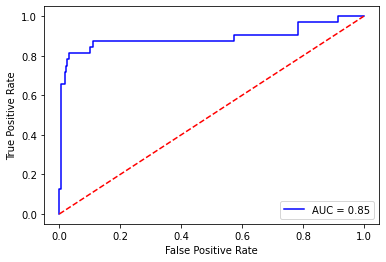

In [51]:
X_test = testing_set.drop('result', axis=1)
y_test = testing_set['result']
metrics2 = pd.DataFrame(metrics)
max_index = metrics2['test_recall'].idxmax()
best_knn = metrics2.iloc[max_index, 2].best_estimator_
print(best_knn)
precision,recall,f1,roc_auc = predict_and_score(best_knn, X_test, y_test)
print(f"Precision: {precision}\nRecall: {recall}\nF1: {f1}\nROC_AUC: {roc_auc}")
draw_roc_curve(best_knn,X_test,y_test)

## Final Model
We recommend using the model found in the "Further experimentation" section. As it leads to the highest values of recall.

KNeighborsClassifier(n_neighbors=1, weights='distance')

Precision: [0.96460177 0.88235294]

Recall: [0.98198198 0.78947368]

F1: 0.8333333333333333

ROC_AUC: 0.8857278330962541

# Logistic Regression

## Hyperparamter Tuning Using Training, Validation, and Test Sets
First we attempt to get the best hyperparameters by splitting the data in training, validation, and Test sets and then fitting different models with different hyperparameters and evaluating the performance on the validation set. We then test the best model using the testing data to obtain our metrics.

## No encoding
First we attempt to fit the model without any changes to act as a baseline.

LogisticRegression(class_weight={0: 0.33999999999999997, 1: 0.66},
                   max_iter=1000, random_state=42)

Precision: [0.92982456 0.6875    ]
Recall: [0.95495495 0.57894737]
F1: 0.6285714285714286
ROC_AUC: 0.7669511616880038


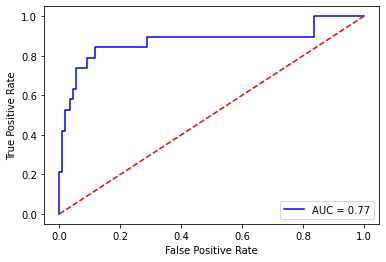

In [25]:
X_train, X_validate, X_test, y_train, y_validate, y_test = split(df)
best_logistic = logistic_validate(X_train, X_validate, y_train, y_validate)
print(best_logistic)
precision,recall,f1,roc_auc = train_test(best_logistic, X_train, X_test, y_train, y_test)
print(f"\nPrecision: {precision}\nRecall: {recall}\nF1: {f1}\nROC_AUC: {roc_auc}")
draw_roc_curve(best_logistic,X_test,y_test)

## One-Hot Encoding
We then encode some of the categorical data in the dataset to improve the metrics.

LogisticRegression(class_weight={0: 0.3899999999999999, 1: 0.6100000000000001},
                   max_iter=1000, random_state=42)

Precision: [0.95575221 0.82352941]
Recall: [0.97297297 0.73684211]
F1: 0.7777777777777778
ROC_AUC: 0.8549075391180655


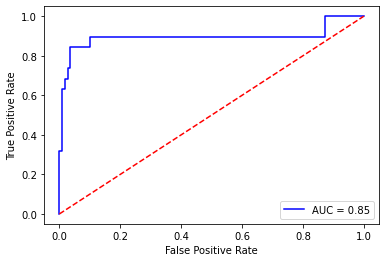

In [26]:
encoded_columns =['symptom1', 'symptom2', 'symptom3', 'symptom4', 'symptom5', 'symptom6', 'location', 'country']
df_encoded = encode(encoded_columns, df)
X_train, X_validate, X_test, y_train, y_validate, y_test = split(df_encoded)
best_logistic = logistic_validate(X_train, X_validate, y_train, y_validate)
print(best_logistic)
precision,recall,f1,roc_auc = train_test(best_logistic, X_train, X_test, y_train, y_test)
print(f"\nPrecision: {precision}\nRecall: {recall}\nF1: {f1}\nROC_AUC: {roc_auc}")
draw_roc_curve(best_logistic,X_test,y_test)

## Scaling 
We then scale the values of the larger dimensions such as 'diff_sym_hos'. In theory we should also scale the age feature, however, experimentally not scaling age results in better metrics. This is explainable by the fact that the result is highly correleated with age, which we know about COVID from a medical perpective. So as such the model should highly favour age in its classification of the result.

LogisticRegression(class_weight={0: 0.2899999999999999, 1: 0.7100000000000001},
                   max_iter=1000, random_state=42)

Precision: [0.96396396 0.78947368]
Recall: [0.96396396 0.78947368]
F1: 0.7894736842105263
ROC_AUC: 0.8767188240872451


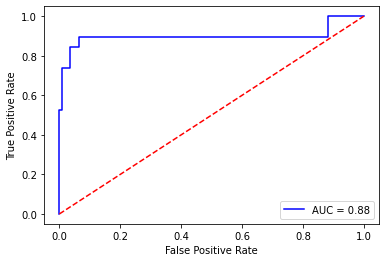

In [27]:
scaled_columns=['diff_sym_hos']
df_scaled = scale(scaled_columns, df_encoded)
X_train, X_validate, X_test, y_train, y_validate, y_test = split(df_scaled)
best_logistic = logistic_validate(X_train, X_validate, y_train, y_validate)
print(best_logistic)
precision,recall,f1,roc_auc = train_test(best_logistic, X_train, X_test, y_train, y_test)
print(f"\nPrecision: {precision}\nRecall: {recall}\nF1: {f1}\nROC_AUC: {roc_auc}")
draw_roc_curve(best_logistic,X_test,y_test)

LogisticRegression(class_weight={0: 0.039999999999999925,
                                 1: 0.9600000000000001},
                   max_iter=1000, random_state=42)

Precision: [0.96226415 0.22077922]
Recall: [0.45945946 0.89473684]
F1: 0.35416666666666663
ROC_AUC: 0.6770981507823612


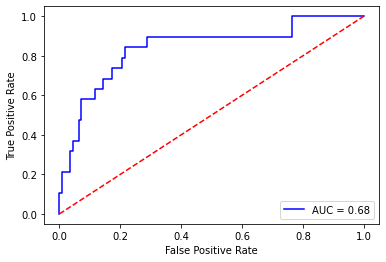

In [28]:
scaled_columns=['age','diff_sym_hos']
df_scaled = scale(scaled_columns, df_encoded)
X_train, X_validate, X_test, y_train, y_validate, y_test = split(df_scaled)
best_logistic = logistic_validate(X_train, X_validate, y_train, y_validate)
print(best_logistic)
precision,recall,f1,roc_auc = train_test(best_logistic, X_train, X_test, y_train, y_test)
print(f"\nPrecision: {precision}\nRecall: {recall}\nF1: {f1}\nROC_AUC: {roc_auc}")
draw_roc_curve(best_logistic,X_test,y_test)

While scaling the 'age' feature increased the recall of the positive class, the precision sharply fell to a point where the model is no longer useful. So we do not scale the age.

## Feature Selection
Previously, we discussed how symptoms 1, 2, and 3 were highly correleated with one another. Additionally, symptom6 had very little correlation with the result. So we drop symptoms 2 and 3 and leave symptom1, then drop symptom6.

LogisticRegression(class_weight={0: 0.1399999999999999, 1: 0.8600000000000001},
                   max_iter=1000, random_state=42)

Precision: [0.98095238 0.68      ]
Recall: [0.92792793 0.89473684]
F1: 0.7727272727272727
ROC_AUC: 0.9113323850165955


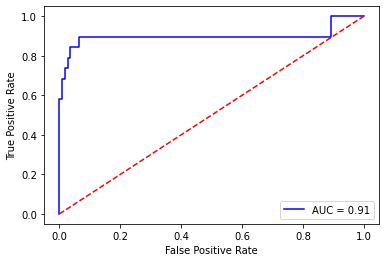

In [29]:
dropped_columns = ['symptom2', 'symptom3', 'symptom6']
encoded_columns =['location', 'symptom1','country','symptom4','symptom5']
scaled_columns=['diff_sym_hos']
df_dropped = drop(dropped_columns, df)
df_encoded = encode(encoded_columns,df_dropped)
df_scaled = scale(scaled_columns, df_encoded)
X_train, X_validate, X_test, y_train, y_validate, y_test = split(df_scaled)
best_logistic = logistic_validate(X_train, X_validate, y_train, y_validate)
print(best_logistic)
precision,recall,f1,roc_auc = train_test(best_logistic, X_train, X_test, y_train, y_test)
print(f"\nPrecision: {precision}\nRecall: {recall}\nF1: {f1}\nROC_AUC: {roc_auc}")
draw_roc_curve(best_logistic,X_test,y_test)

## Further Experimentation
Here we experimentally select features. After some experiments this is the best result.

LogisticRegression(class_weight={0: 0.18999999999999995, 1: 0.81},
                   max_iter=1000, random_state=42)

Precision: [0.97247706 0.76190476]
Recall: [0.95495495 0.84210526]
F1: 0.8
ROC_AUC: 0.8985301090564248


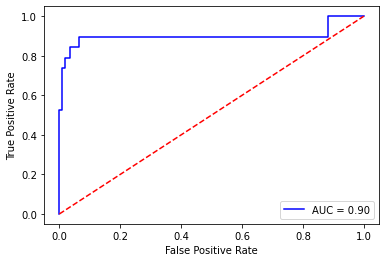

In [30]:
dropped_columns = ['symptom2','symptom3' ,'symptom4', 'symptom5', 'symptom6']
encoded_columns =['symptom1', 'location','country']
scaled_columns=['diff_sym_hos']
df_dropped = drop(dropped_columns, df)
df_encoded = encode(encoded_columns,df_dropped)
df_scaled = scale(scaled_columns, df_encoded)
X_train, X_validate, X_test, y_train, y_validate, y_test = split(df_scaled)
best_logistic = logistic_validate(X_train, X_validate, y_train, y_validate)
print(best_logistic)
train_test(best_logistic, X_train, X_test, y_train, y_test)
precision,recall,f1,roc_auc = train_test(best_logistic, X_train, X_test, y_train, y_test)
print(f"\nPrecision: {precision}\nRecall: {recall}\nF1: {f1}\nROC_AUC: {roc_auc}")
draw_roc_curve(best_logistic,X_test,y_test)

## Using GridSearch to Find Optimal Hyperparameters and Perform Cross-Validation

LogisticRegression(class_weight={0: 0.039999999999999925,
                                 1: 0.9600000000000001},
                   random_state=42)
Precision: [0.98445596 0.43939394]
Recall: [0.83700441 0.90625   ]
F1: 0.5918367346938775
ROC_AUC: 0.8716272026431718


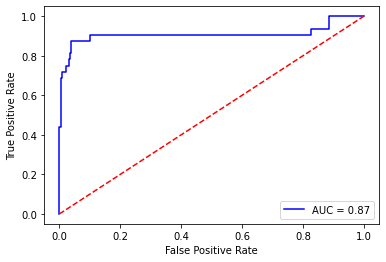

In [31]:
dropped_columns = ['symptom2', 'symptom3','symptom6']
encoded_columns =['location', 'symptom1','symptom5','country','symptom4']
scaled_columns=['diff_sym_hos']

df_dropped = drop(dropped_columns, df)
df_encoded = encode(encoded_columns,df_dropped)

df_scaled = scale(scaled_columns,df_encoded)
x = df_scaled.drop('result', axis=1)
y = df_scaled['result']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3,shuffle=True, random_state=42)

weights = []
for i in np.arange(0.01,1,0.05):
    weights.append({0:1 - i, 1:i})

weights.append('balanced')

parameters = {'class_weight':weights}

logistic = LogisticRegression(random_state=42)
grid_search = GridSearchCV(logistic, parameters, scoring='recall', cv=5)
grid_search.fit(X_train, y_train)
best_logistic = grid_search.best_estimator_
best_logistic.fit(X_train, y_train)

y_predict = best_logistic.predict(X_test)
precision= precision_score(y_test, y_predict,average=None)
recall = recall_score(y_test,y_predict,average=None)
roc_auc = roc_auc_score(y_test, y_predict)
f1 = f1_score(y_test.values, y_predict)

print(best_logistic)
print(f"Precision: {precision}\nRecall: {recall}\nF1: {f1}\nROC_AUC: {roc_auc}")
draw_roc_curve(best_logistic,X_test,y_test)

While this yields a decent recall in the positive class, however, the precision of the positive class is too low to be useful.

In [32]:
df = pd.read_csv('data.csv',index_col=0)
#Negative hours changed to positive
for i in range(len(df)):
    df.iloc[i, 12] = df.iloc[i,12]*-1 if df.iloc[i, 12] < 0 else df.iloc[i, 12]

#Gender value 2 changed to the most common gender
df['gender'] = df['gender'].mask(df['gender'] == 2, 1)

## Using RepeatedStratifiedKFold and cross_validate

In [ ]:
dropped_columns = ['symptom2', 'symptom3','symptom5', 'symptom6','country','symptom4']
encoded_columns =['location', 'symptom1']
scaled_columns=['diff_sym_hos']

df_kfold_logist = drop(dropped_columns,df)
df_kfold_logist = encode(encoded_columns, df_kfold_logist)

for col in encoded_columns:
    df_kfold_logist.drop(f'{col}_0', inplace=True, axis=1)

df_kfold_logist = scale(scaled_columns,df_kfold_logist)



weights = []

for i in np.arange(0.01,1,0.05):
    weights.append({0:1 - i, 1:i})

weights.append('balanced')

parameters = {'class_weight':weights}

logistic = LogisticRegression(random_state=42)
grid_search = GridSearchCV(logistic, parameters, scoring='recall', cv=5)

training_set, testing_set = train_test_split(df_kfold_logist, test_size=0.3,shuffle=True, random_state=42)
X_training = training_set.drop('result', axis=1)
y_training = training_set['result']
KFolds = RepeatedStratifiedKFold(n_splits = 5,n_repeats=5, random_state=42)

custom_scorer = {'accuracy': make_scorer(accuracy_score),
                 'precision': make_scorer(precision_score, average='binary'),
                 'recall': make_scorer(recall_score, average='binary'),
                 'f1': make_scorer(f1_score,average='binary'),
                 'aoc_roc': make_scorer(roc_auc_score)
                 }

metrics = cross_validate(grid_search,X_training.values,y_training.values,scoring = custom_scorer, cv = KFolds,return_estimator= True)

In [ ]:
X_test = testing_set.drop('result', axis=1)
y_test = testing_set['result']

metrics2 = pd.DataFrame(metrics)
max_index = metrics2['test_recall'].idxmax()
best_logistic = metrics2.iloc[max_index, 2].best_estimator_

print(best_logistic)
precision,recall,f1,roc_auc = predict_and_score(best_logistic, X_test, y_test)
print(f"Precision: {precision}\nRecall: {recall}\nF1: {f1}\nROC_AUC: {roc_auc}")
draw_roc_curve(best_logistic,X_test,y_test)

## Final Model
We recommend using the model found in the "Using RepeatedStratifiedKFold and cross_validate" section. As it leads to the highest values of recall.


LogisticRegression(class_weight='balanced', random_state=42)

Precision: [0.98604651 0.65909091]

Recall: [0.9339207 0.90625  ]

F1: 0.763157894736842

ROC_AUC: 0.9200853524229076
 

# Gaussian Naive Bayes

## Hyperparamter Tuning Using Training, Validation, and Test Sets
First we attempt to get the best hyperparameters by splitting the data in training, validation, and Test sets and then fitting different models with different hyperparameters and evaluating the performance on the validation set. We then test the best model using the testing data to obtain our metrics.

## No encoding
First we attempt to fit the model without any changes to act as a baseline.

GaussianNB(var_smoothing=5.336699231206313e-07)

Precision: [0.95789474 0.42857143]
Recall: [0.81981982 0.78947368]
F1: 0.5555555555555555
ROC_AUC: 0.8046467520151731


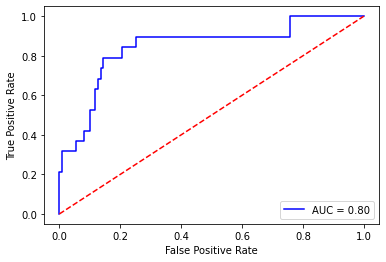

In [35]:
X_train, X_validate, X_test, y_train, y_validate, y_test = split(df)
df_nn = pd.DataFrame()
best_gnb = gnb_validate(X_train, X_validate, y_train, y_validate)
print(best_gnb)
precision,recall,f1,roc_auc = train_test(best_gnb, X_train, X_test, y_train, y_test)
print(f"\nPrecision: {precision}\nRecall: {recall}\nF1: {f1}\nROC_AUC: {roc_auc}")
draw_roc_curve(best_gnb,X_test,y_test)

## One-Hot Encoding
We then encode some of the categorical data in the dataset to improve the metrics. In logistic regression we need to make sure none of the features are dependant on each other and as such we remove one of each of the hot-encoded columns.

GaussianNB(var_smoothing=4.328761281083062e-05)

Precision: [0.95081967 0.23188406]
Recall: [0.52252252 0.84210526]
F1: 0.36363636363636365
ROC_AUC: 0.6823138928402086


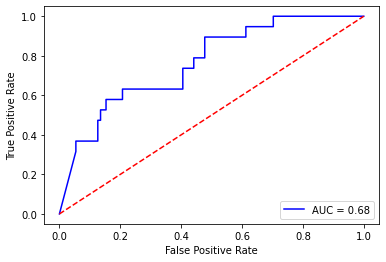

In [36]:
encoded_columns =['symptom1', 'symptom2', 'symptom3', 'symptom4', 'symptom5', 'symptom6', 'location', 'country']
df_encoded = encode(encoded_columns, df)
X_train, X_validate, X_test, y_train, y_validate, y_test = split(df_encoded)
best_gnb = gnb_validate(X_train, X_validate, y_train, y_validate)
print(best_gnb)
precision,recall,f1,roc_auc = train_test(best_gnb, X_train, X_test, y_train, y_test)
print(f"\nPrecision: {precision}\nRecall: {recall}\nF1: {f1}\nROC_AUC: {roc_auc}")
draw_roc_curve(best_gnb,X_test,y_test)

While the recall increased the precision of the model sharply fell, this prompts us to not encode our data later on.

## Scaling
We then scale the values of the larger dimensions such as 'diff_sym_hos'. In theory we should also scale the age feature, however, experimentally not scaling age results in better metrics. This is explainable by the fact that the result is highly correleated with age, which we know about COVID from a medical perpective. So as such the model should highly favour age in its classification of the result.

GaussianNB(var_smoothing=5.336699231206313e-07)

Precision: [0.95789474 0.42857143]
Recall: [0.81981982 0.78947368]
F1: 0.5555555555555555
ROC_AUC: 0.8046467520151731


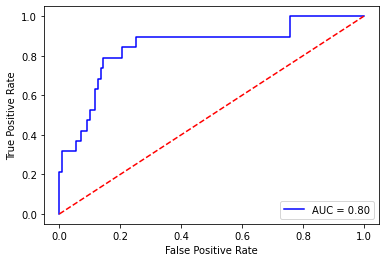

In [37]:
# scaled_columns =['age', 'diff_sym_hos']
scaled_columns=['diff_sym_hos']
df_scaled = scale(scaled_columns, df)
X_train, X_validate, X_test, y_train, y_validate, y_test = split(df_scaled)
best_gnb = gnb_validate(X_train, X_validate, y_train, y_validate)
print(best_gnb)
precision,recall,f1,roc_auc = train_test(best_gnb, X_train, X_test, y_train, y_test)
print(f"\nPrecision: {precision}\nRecall: {recall}\nF1: {f1}\nROC_AUC: {roc_auc}")
draw_roc_curve(best_gnb,X_test,y_test)

GaussianNB(var_smoothing=4.3287612810830526e-07)

Precision: [0.95698925 0.40540541]
Recall: [0.8018018  0.78947368]
F1: 0.5357142857142857
ROC_AUC: 0.7956377430061642


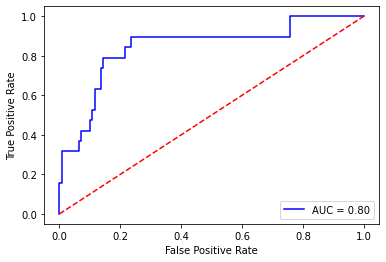

In [38]:
scaled_columns =['age', 'diff_sym_hos']
df_scaled = scale(scaled_columns, df)
X_train, X_validate, X_test, y_train, y_validate, y_test = split(df_scaled)
best_gnb = gnb_validate(X_train, X_validate, y_train, y_validate)
print(best_gnb)
precision,recall,f1,roc_auc = train_test(best_gnb, X_train, X_test, y_train, y_test)
print(f"\nPrecision: {precision}\nRecall: {recall}\nF1: {f1}\nROC_AUC: {roc_auc}")
draw_roc_curve(best_gnb,X_test,y_test)

> This shows experimentally that 'age' should not be scaled.

## Feature Selection
For Gaussian Naive Bayes we chose to add only the features that are from a gaussian distribution to our features these included: age,diff_sym_hos.

Additionally, through experimentation it was found that the 'location' and 'vis_wuhan' features added to the model's metrics.

GaussianNB(var_smoothing=0.0002848035868435802)
Index(['age', 'diff_sym_hos', 'result', 'location', 'vis_wuhan'], dtype='object')

Precision: [0.95652174 0.93333333]
Recall: [0.99099099 0.73684211]
F1: 0.8235294117647058
ROC_AUC: 0.8639165481270744


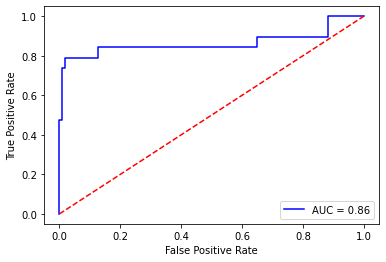

In [39]:
df_bayes = df[['age','diff_sym_hos','result','location','vis_wuhan']]
df_scaled = scale(['location','diff_sym_hos'], df_bayes)
X_train, X_validate, X_test, y_train, y_validate, y_test = split(df_scaled)
best_gnb = gnb_validate(X_train, X_validate, y_train, y_validate)
print(best_gnb)
print(df_bayes.columns)
precision,recall,f1,roc_auc = train_test(best_gnb, X_train, X_test, y_train, y_test)
print(f"\nPrecision: {precision}\nRecall: {recall}\nF1: {f1}\nROC_AUC: {roc_auc}")
draw_roc_curve(best_gnb,X_test,y_test)

## Using GridSearch to Find Optimal Hyperparameters and Perform Cross-Validation

GaussianNB(var_smoothing=5.3366992312063123e-05)
Precision: [0.96551724 0.88888889]
Recall: [0.98678414 0.75      ]
F1: 0.8135593220338982
ROC_AUC: 0.8683920704845816


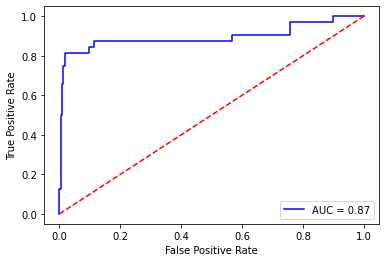

In [40]:
df_bayes = df[['age','diff_sym_hos','result','location','vis_wuhan']]
df_scaled = scale(['location', 'diff_sym_hos'], df_bayes)
x = df_scaled.drop('result', axis=1)
y = df_scaled['result']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3,shuffle=True, random_state=42)

parameters = {'var_smoothing': np.logspace(0,-9, num=100)}

gnb = GaussianNB()
grid_search = GridSearchCV(gnb, parameters, scoring='recall', cv=5)
grid_search.fit(X_train, y_train)
best_gnb = grid_search.best_estimator_
best_gnb.fit(X_train, y_train)

y_predict = best_gnb.predict(X_test)
precision= precision_score(y_test, y_predict,average=None)
recall = recall_score(y_test,y_predict,average=None)
roc_auc = roc_auc_score(y_test, y_predict)
f1 = f1_score(y_test.values, y_predict)

print(best_gnb)
print(f"Precision: {precision}\nRecall: {recall}\nF1: {f1}\nROC_AUC: {roc_auc}")
draw_roc_curve(best_gnb,X_test,y_test)

## Using RepeatedStratifiedKFold and cross_validate

In [41]:
df_bayes = df[['age','diff_sym_hos','result','location','vis_wuhan']]
df_scaled = scale(['location', 'diff_sym_hos'], df_bayes)


parameters = {'var_smoothing': np.logspace(0,-9, num=100)}

gnb = GaussianNB()
grid_search = GridSearchCV(gnb, parameters, scoring='recall', cv=5)

training_set, testing_set = train_test_split(df_scaled, test_size=0.3,shuffle=True, random_state=42)
X_training = training_set.drop('result', axis=1)
y_training = training_set['result']
KFolds = RepeatedStratifiedKFold(n_splits = 5,n_repeats=5, random_state=42)

custom_scorer = {'accuracy': make_scorer(accuracy_score),
                 'precision': make_scorer(precision_score, average='binary'),
                 'recall': make_scorer(recall_score, average='binary'),
                 'f1': make_scorer(f1_score,average='binary'),
                 'aoc_roc': make_scorer(roc_auc_score)
                 }

metrics = cross_validate(grid_search,X_training.values,y_training.values,scoring = custom_scorer, cv = KFolds,return_estimator= True)

GaussianNB(var_smoothing=6.579332246575683e-05)
Precision: [0.96103896 0.82142857]
Recall: [0.97797357 0.71875   ]
F1: 0.7666666666666666
ROC_AUC: 0.8483617841409692


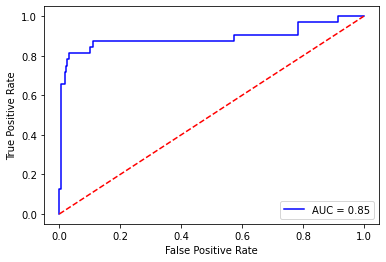

In [42]:
X_test = testing_set.drop('result', axis=1)
y_test = testing_set['result']
metrics2 = pd.DataFrame(metrics)
max_index = metrics2['test_recall'].idxmax()
best_gnb = metrics2.iloc[max_index, 2].best_estimator_
print(best_gnb)
precision,recall,f1,roc_auc = predict_and_score(best_gnb,X_test, y_test)
print(f"Precision: {precision}\nRecall: {recall}\nF1: {f1}\nROC_AUC: {roc_auc}")
draw_roc_curve(best_gnb,X_test,y_test)

## Final Model
We recommend using the model found in the "Using GridSearch to Find Optimal Hyperparameters and Perform Cross-Validation" section. As it leads to the highest values of recall.

GaussianNB(var_smoothing=5.3366992312063123e-05)

Precision: [0.96551724 0.88888889]

Recall: [0.98678414 0.75      ]

F1: 0.8135593220338982

ROC_AUC: 0.8683920704845816


# Comparison Between the Different Algorithms

In [50]:
models_comparision_dic = {
    'model':['KNN', 'Logistic Regression', 'Naive Bayes'],
    'optimal_hyperparameters': ['k = 1, weights = distance', 'class weights: balanced', 'var_smoothing: 5.3366992312063123e-05'],
    'precision': ['zero class = 0.96460177, one class = 0.88235294',  'zero: 0.98604651, one class = 0.65909091 ', ' zero class = 0.96551724, one class = 0.88888889'],
    'recall': ['zero class = 0.98198198, one class = 0.78947368' ,'zero class = 0.9339207, one class = 0.90625','zero class = 0.98678414, one class = 0.75 ' ],
    'F1': [0.8333333333333333, 0.763157894736842 ,  0.8135593220338982],
    'ROC_AUC': [0.8857278330962541, 0.9200853524229076 , 0.8683920704845816]
}

models_comaprision_df = pd.DataFrame(models_comparision_dic)
models_comaprision_df

,model,optimal_hyperparameters,precision,recall,F1,ROC_AUC
0,KNN,"k = 1, weights = distance","zero class = 0.96460177, one class = 0.88235294","zero class = 0.98198198, one class = 0.78947368",0.833333,0.885728
1,Logistic Regression,class weights: balanced,"zero: 0.98604651, one class = 0.65909091","zero class = 0.9339207, one class = 0.90625",0.763158,0.920085
2,Naive Bayes,var_smoothing: 5.3366992312063123e-05,"zero class = 0.96551724, one class = 0.88888889","zero class = 0.98678414, one class = 0.75",0.813559,0.868392


# Bonus Section: Utilising Bagging Classifier to Improve Naive Bayes

In [48]:
df_bayes = df[['age','diff_sym_hos','result','location','vis_wuhan']]
df_scaled = scale(['location', 'diff_sym_hos'], df_bayes)

x = df_scaled.drop('result', axis=1)
y = df_scaled['result']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3,shuffle=True, random_state=42)

gnb_bagging = GaussianNB()
bagging_classifier = BaggingClassifier(gnb_bagging, random_state=42, max_samples=1.0)

parameters = {
    'base_estimator__var_smoothing':np.logspace(0,-9, num=100),
    'max_features': np.arange(2, 13, 1),
}

grid_search = GridSearchCV(bagging_classifier, parameters, scoring='recall', cv=5)
best_gnb = grid_search.fit(X_train, y_train)
best_gnb.fit(X_train, y_train)
y_predict = best_gnb.predict(X_test)

BaggingClassifier(base_estimator=GaussianNB(var_smoothing=8.111308307896872e-07),
                  max_features=4, random_state=42)
Accuracy: 0.9420849420849421
Precision: [0.96491228 0.77419355]
Recall: [0.969163 0.75    ]
F1: 0.7666666666666666
ROC_AUC: 0.8595814977973568


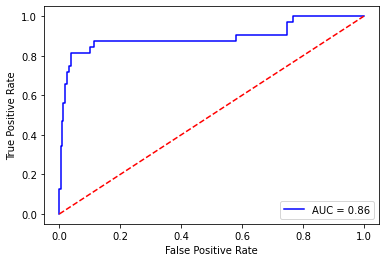

In [49]:
accuracy = accuracy_score(y_test,y_predict)
precision= precision_score(y_test, y_predict,average=None)
recall = recall_score(y_test,y_predict,average=None)
roc_auc = roc_auc_score(y_test, y_predict)
F1 = f1_score(y_test, y_predict)
print(best_gnb.best_estimator_)

print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1: {f1}\nROC_AUC: {roc_auc}")
draw_roc_curve(best_gnb,X_test,y_test)